In [1]:
import requests
import json
import pandas as pd
from config import api_key
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy.stats import linregress

In [2]:
#base URL
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

#Set parameters
start_year = '2013'
end_year = '2021'
series_id = 'CUUR0000SA0'

#API call to get the data
headers = {'Content-type': 'application/json'}
data = json.dumps({'seriesid': [series_id],'startyear':start_year, 'endyear':end_year})
response = requests.post(url, data=data, headers=headers)
cpi_data = json.loads(response.text)
cpi_data

{'status': 'REQUEST_SUCCEEDED',
 'responseTime': 220,
 'message': [],
 'Results': {'series': [{'seriesID': 'CUUR0000SA0',
    'data': [{'year': '2021',
      'period': 'M06',
      'periodName': 'June',
      'latest': 'true',
      'value': '271.696',
      'footnotes': [{}]},
     {'year': '2021',
      'period': 'M05',
      'periodName': 'May',
      'value': '269.195',
      'footnotes': [{}]},
     {'year': '2021',
      'period': 'M04',
      'periodName': 'April',
      'value': '267.054',
      'footnotes': [{}]},
     {'year': '2021',
      'period': 'M03',
      'periodName': 'March',
      'value': '264.877',
      'footnotes': [{}]},
     {'year': '2021',
      'period': 'M02',
      'periodName': 'February',
      'value': '263.014',
      'footnotes': [{}]},
     {'year': '2021',
      'period': 'M01',
      'periodName': 'January',
      'value': '261.582',
      'footnotes': [{}]},
     {'year': '2020',
      'period': 'M12',
      'periodName': 'December',
      'valu

In [3]:
#Preparing the lists which will go to the DataFrame 
Year = []
Month = []
CPI_value = []

#Extracting the values from the API response
for series in cpi_data['Results']['series']:
    seriesId = series['seriesID']
    for item in series['data']:
        year = item['year']
        Year.append(year)
        period = item['period']
        Month.append(period)
        value = item['value']
        CPI_value.append(value)

#Creating the DataFrame        
CPI_data_df = pd.DataFrame({'Year':Year,'Month':Month,'CPI Value':CPI_value})  

#Renaming month values
CPI_data_df['Month'] = CPI_data_df['Month'].replace(
    {'M01':'Jan',
     'M02':'Feb',
     'M03':'Mar',
     'M04':'Apr',
     'M05':'May',
     'M06':'Jun',
     'M07':'Jul',
     'M08':'Aug',
     'M09':'Sep',
     'M10':'Oct',
     'M11':'Nov',
     'M12':'Dec'
    })        

#Saving the data to output_data folder (as csv file)
CPI_data_df.to_csv('./output_data/CPI_data.csv',index=False)

In [4]:
#Converting our str values from 'Year' & 'Month' columns to create dates in mm-dd-yyyy format (added days as 1st day of the month)
#Need this format for plotting CPI data on the graph
year_list = CPI_data_df['Year'].tolist()
month_list = CPI_data_df['Month'].tolist()
date_list = []
for index in range(len(year_list)):
    date_str = month_list[index] + ' 1 ' + year_list[index]
    date_input = datetime.strptime(date_str,'%b %d %Y')
    date_list.append(date_input)

#Reversed my data to start from earliest dates to latest
date_list.reverse()



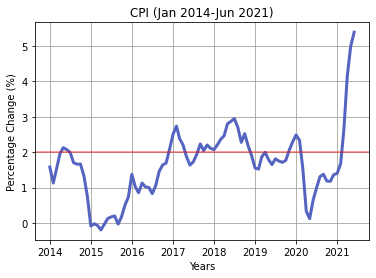

In [5]:
#Get the list of CPI values
CPI_data_list = CPI_data_df['CPI Value'].tolist()

#Get the lists for calculating percentage change
CPI_percentage_current = CPI_data_list[:len(CPI_data_list)-12]
CPI_percentage_previous = CPI_data_list[12:]

#Result list of the percentage change (months)
CPI_percentage_YoY = []

#Getting the values for 'CPI_percentage_YoY' list
for index in range(len(CPI_percentage_previous)):
    a = float(CPI_percentage_current[index])
    b = float(CPI_percentage_previous[index])
    percentage_change = ((a / b)- 1) * 100
    CPI_percentage_YoY.append(percentage_change)

#Reversing the CPI percentage values to start from earliest dates to latest
CPI_percentage_YoY.reverse()
CPI_percentage = CPI_percentage_YoY

#Extracting the data to start from Jan 2014 to Jun 2021
new_date_list = []
new_date_list = date_list[12:]

#Plotting Line Graph
plt.plot(new_date_list, CPI_percentage, linewidth=3, color='#5464C0')

#Adding grid lines for better readability 
plt.grid(color='#9FA095', alpha=1)

#Putting horizontal line to show acceptable inflation rate, which is around 2% or a bit below (I plotted the line at 2%)
plt.axhline(y=2, color='r',linestyle='-', alpha=0.5)

#Plotting Title and x/y labels
plt.title('CPI (Jan 2014-Jun 2021)')
plt.xlabel('Years')
plt.ylabel('Percentage Change (%)')

#Save and display the chart
plt.savefig('output_data/inflation_visuals/cpi_percent_change_visual.png')
plt.show()

## Observation:

This is Inflation rate month by month from Jan 2014 to Jun 2021 in the USA. Note I use CPI (Consumer Price Index) as it is a good measure of inflation.

The Federal Reserve has not established a formal inflation target, but policymakers generally believe that an acceptable inflation rate is around 2% or a bit below. (This statement is taken from Fderal Reserve website https://www.federalreserve.gov/faqs/5D58E72F066A4DBDA80BBA659C55F774.htm#:~:text=What%20is%20an%20acceptable%20level%20of%20inflation%3F%20The,is%20around%202%20percent%20or%20a%20bit%20below.)

As you can see on the graph, there were years with the inflation rate being over the 2% (the red line). This may or may not affect car manufacturer's stock prices or US car sales overall. Let's get more data and make some analysis.

In [6]:
#The path to our car manuf. stock CSV file
stock_prices_file = "output_data/carstockprices.csv"

# Read our carstockprices.csv data into pandas
Car_Stock_df = pd.read_csv(stock_prices_file)
Car_Stock_df.head()

,Date,Open,High,Low,Close,Volume,Ticker
0,2014-01-02,10.930932,10.952198,10.831689,10.945109,31528500,F
1,2014-01-03,11.001821,11.086886,10.845867,10.994732,46122300,F
2,2014-01-06,11.143596,11.171951,11.001820,11.044353,42657600,F
3,2014-01-07,11.150682,11.157771,10.881308,10.902575,54476300,F
4,2014-01-08,11.058531,11.136508,10.994732,11.015998,48448300,F


In [7]:
#Defining a general function to create Linear Regression Plots
def plot_linear_regression(x_values, y_values, x_line_eq, y_line_eq, x_label, y_label, title):
    
    #Perform  Linear Regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values) 
    
    #Get regression values
    regress_values = [i * slope + intercept for i in x_values]
    
    #Create line equation string
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
    #Create Scatter Plot
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r-")
    
    #Displaying equation on the plot
    plt.annotate(line_eq,(x_line_eq, y_line_eq),fontsize=15,color="red")
    
    #Labels and Title
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    #Printing r-values
    print(f'The r-value is: {rvalue**2}')

In [8]:
#####################################################################################
# Create car stocks (10 manufacturers) DataFrame grouping stock Close prices by month
#####################################################################################

#Create year and month lists to be added to car stocks dataframe (will be used to groupby by year and month)
month_list = []
year_list = []
for index in Car_Stock_df.index:
    date_str = Car_Stock_df['Date'][index]
    year_list.append(int(date_str[0:4]))
    month_list.append(int(date_str[5:7]))

#Add year and month lists to dataframe
Car_Stock_df['Year'] = year_list
Car_Stock_df['Month'] = month_list

#Group by Ticker, Year, Month and use the mean for the close price (I use the average stock price per month)
Car_Stock_Month_df = Car_Stock_df.groupby(['Ticker','Year','Month']).mean()
#Remove uncessary column from dataframe
del Car_Stock_Month_df['Open']
del Car_Stock_Month_df['High']
del Car_Stock_Month_df['Low']
del Car_Stock_Month_df['Volume']

#Move indexes into columns
Car_Stock_Month_df.reset_index(inplace=True)
Car_Stock_Month_df.head()

#############################################################################
# Update newly created DataFrame with 1 new column (price percentage change)
#############################################################################

#Create stock price percentage list
percentage_stock_change = []

#Initialize variables used to calculate percentage change
stock_change = 0     # 0 = same stock (keep calulating the percentage change (same ticker)); 1 = new stock (set to 0 (start calculating new stock))
current_stock = ''   # initalize stock ticker name

#Calculate percentage change and store values in list
for index in Car_Stock_Month_df.index:
    #Check if I am reading and new stock (ticker)
    if current_stock != Car_Stock_Month_df['Ticker'][index]:
        stock_change = 1
        current_stock = Car_Stock_Month_df['Ticker'][index]
    else:
        stock_change = 0
    
    #Calculate percentage change and add it to the list
    if stock_change == 1:
        percentage_stock_change.append(0)
    else:
        a = Car_Stock_Month_df['Close'][index]
        b = Car_Stock_Month_df['Close'][index-1]
        percentage_stock_change.append((a/b-1)*100)

#Add column to Data Frame with percentage change values
Car_Stock_Month_df['% Change'] = percentage_stock_change

#################################################################
# Create CPI % DataFrame
#################################################################
CPI_df = pd.DataFrame({"Date":new_date_list,"CPI %":CPI_percentage})

#Create month and year lists
month_list = []
year_list = []

#Save years and months values (int format)
for index in range(len(new_date_list)):
    date_str = new_date_list[index]
    year_list.append(date_str.year)
    month_list.append(date_str.month)

#Add columns to Data Frame with years and months values
CPI_df['Year']= year_list
CPI_df['Month']= month_list

#################################################################
# Merge Car_Stock_Month_df and CPI_df
#################################################################
CarStock_CPI_df = pd.merge(Car_Stock_Month_df, CPI_df,how = 'left', on=['Year','Month'])

CarStock_CPI_df.head()

,Ticker,Year,Month,Close,% Change,Date,CPI %
0,DDAIF,2014,1,62.523280,0.000000,2014-01-01,1.578947
1,DDAIF,2014,2,64.703957,3.487784,2014-02-01,1.126349
2,DDAIF,2014,3,66.824932,3.277968,2014-03-01,1.512203
3,DDAIF,2014,4,69.494203,3.994424,2014-04-01,1.952858
4,DDAIF,2014,5,68.710423,-1.127835,2014-05-01,2.127112


The r-value is: 4.525792667632709e-06


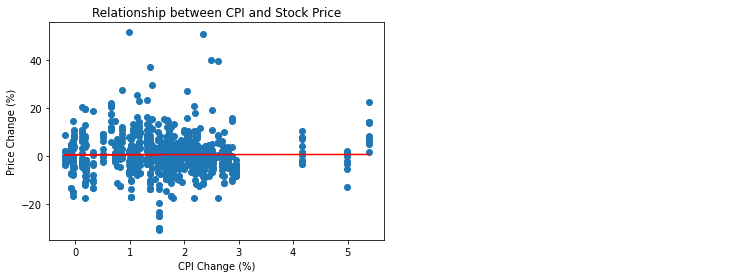

In [9]:
#Display scatter plot and R-value for stock price change(%) and CPI change(%)
a = CarStock_CPI_df['CPI %'].tolist()
b = CarStock_CPI_df['% Change'].tolist()
plot_linear_regression(a, b, 10, 0,'CPI Change (%)', 'Price Change (%)', 'Relationship between CPI and Stock Price')

#Save and display the chart
plt.savefig('output_data/inflation_visuals/cpichange_vs_stockpricechange_visual.png')
plt.show()       

## Observation:

The above graph shows the correlation between CPI change and stock prices change (10 chosen car manufacturers). From the this graph, it is very obvious that there is no correlation whatsoever between these 2 variables (the R-value is basically zero). Some conclusions we can make here:

1 - Car manufacturers stock price is influenced by global sales (not only US sales).

2 - Inflation in other countries might be totally different than in the US (sales in other countries might be fine as here in the US, it is bad, and vice versa). 

3 - News that have nothing to do with inflation (e.g. press releases) can affect stock price.

...and more

Since USA Inflation Rate does not affect stock price for these car manufacturers, let's look at the US Car Sales and see if we can find more correlation (against the US Inflation).


In [10]:
#Read Car sales
US_car_sales_df = pd.read_csv('output_data/US_car_sales_20142021.csv')
US_car_sales_df = US_car_sales_df.dropna(how='any')
US_car_sales_df.head()

,Date,Car sales
0,12/1/2013,1350623
1,1/1/2014,1006049
2,2/1/2014,1186038
3,3/1/2014,1529348
4,4/1/2014,1381300


The r-value is: 0.008893983468200913


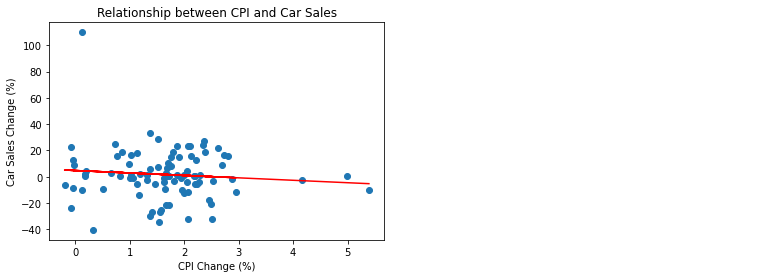

In [11]:
#Compute percentage car sales for each month
percentage_car_sales_list = []
for index in range(1,len(US_car_sales_df)):
    a = US_car_sales_df['Car sales'][index]
    b = US_car_sales_df['Car sales'][index-1]
    percentage_car_sales = ((a/b)-1)*100
    percentage_car_sales_list.append(percentage_car_sales)
    
#Linear regression of CPI % vs. Car Sales Change % (scatter plot)
plot_linear_regression(CPI_percentage, percentage_car_sales_list, 10, 0,'CPI Change (%)', 'Car Sales Change (%)', 'Relationship between CPI and Car Sales')

#Save and display the chart
plt.savefig('output_data/inflation_visuals/cpichange_vs_carsaleschange_visual.png')
plt.show()      

## Observation:

Again, there is no correlation between the US sales and the US inflation (R-value is basically zero). Here are some thoughts on
why this is uncorrelated: 

1 - The government has mechanisms and tools to address inflation (print money, extend unemployment benefits, etc.), which helps protect the US consumers purchasing power and keep the enonomy up (incl.  car sales).

2 - Interest rates have a much bigger impact on sales (or stock price) as they dictate the price of financing ,and indirectly affordability (higher interest rate means higher monthly payments).

3 - Inflation does not affect the economy straight away. It might take a few months before we see the impact of inflation on the economy.

As stated in 3rd point, the impact of inflation can be seen later in time. Let's analyze the data and see how the correlation changes when we look at the impact of inflation on future car sales. 

R-value:

R-value is 0.007110463280730826 if shifting 0 month(s).
R-value is 0.018020499026651766 if shifting 1 month(s).
R-value is 0.0075242997149397185 if shifting 2 month(s).
R-value is 1.0991294144017265e-06 if shifting 3 month(s).
R-value is 0.0014814536616119503 if shifting 4 month(s).
R-value is 0.0016953826526353863 if shifting 5 month(s).
R-value is 0.001208933579203119 if shifting 6 month(s).
R-value is 9.29314690260873e-05 if shifting 7 month(s).
R-value is 0.00013179869411375302 if shifting 8 month(s).
R-value is 2.5212696445318366e-05 if shifting 9 month(s).
R-value is 0.0008664968331503232 if shifting 10 month(s).
R-value is 0.00022590239528460523 if shifting 11 month(s).
R-value is 3.143667448081845e-05 if shifting 12 month(s).


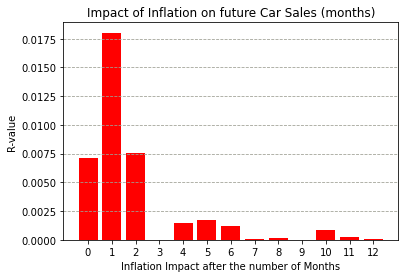

In [15]:
#The impact of inflation may not affect sales straight away but rather some time in the future. Let's shift our inflation 
# back in time and look the future sales dates.
# One month in the future -> I compare CPI from Dec 2014 to May 2021 to car sales from Jan 2015 to Jun 2021
# Two months in the future -> I compare CPI from November 2014 to April 2021 to car sales from Jan 2015 to Jun 2021
# and so on...

#Defining function that returns R-value (square)
def r_value_function(x_values, y_values):
    
    #Perform  Linear Regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values) 
    return rvalue**2

#Initialize lists to compute R-value
Car_Sales_2015_2021 = []
Car_Sales_2015_2021 = percentage_car_sales_list[12:]
CPI_percentage_delay = []

#Compute R-value square if we delay CPI data by 0 to 11 months
r_value = []
print('R-value:\n')
for month_delay in range (0,13):
    CPI_percentage_delay = CPI_percentage[12-month_delay:len(CPI_percentage)-month_delay]
    r = r_value_function(CPI_percentage_delay, Car_Sales_2015_2021)
    print(f'R-value is {r} if shifting {month_delay} month(s).')
    r_value.append(r)

#Plot R-value 
x_axis = [0,1,2,3,4,5,6,7,8,9,10,11,12]
plt.bar(x_axis,r_value, color='r')
plt.xticks(x_axis)    #otherwise not all numbers are displayed on my x axis

#Adding horisontal grids for better visibility
axes = plt.gca()
axes.yaxis.grid(linestyle='--', color='#9FA095')

#Title and labels
plt.title('Impact of Inflation on future Car Sales (months)')
plt.xlabel('Inflation Impact after the number of Months')
plt.ylabel('R-value')

#Show the plot
plt.savefig('output_data/inflation_visuals/inflation_vs_futurecarsales_visual.png')
plt.show()

## Observation:

Unfortunately, by looking at the R-values (all are very close to zero). I conclude that the US car sales and US inflation are not correlated by any means. I had an assumption that inflation could affect sales later on, but it is not true, as you can see on the above graph.  

In [13]:
#Re-order list from earliest to latest CPI value
CPI_data_list.reverse()

#Store car sales in list
a = US_car_sales_df['Car sales'].tolist()
US_car_sales_list = a[1:]     #remove first sale (last sale of 2013)

#Store CPI data in list
b = CPI_data_df['CPI Value'].tolist()
b.reverse()     #Re-order list from earliest to latest CPI value
CPI_data_list = b[12:]     #align dates with US car sales

#Convert CPI data to float and save data in list
CPI_data_number_list = []
for index in range(len(CPI_data_list)):
    a = float(CPI_data_list[index])
    CPI_data_number_list.append(a)

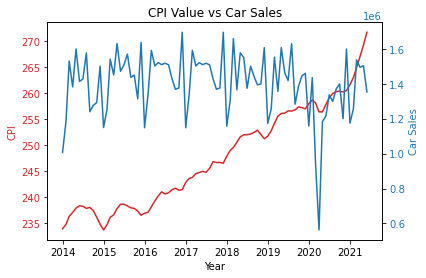

In [14]:
#Plot both CPI value and car sales on one graph
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('CPI', color=color)
ax1.plot(new_date_list, CPI_data_number_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()    #instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Car Sales', color=color)    #we already handled the x-label with ax1
ax2.plot(new_date_list, US_car_sales_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#Title
plt.title('CPI Value vs Car Sales')

#Show the plot
plt.savefig('output_data/inflation_visuals/cpi_vs_carsales_overyrs_visual.png')
plt.show()

## Observation:

Putting CPI values and car sales on the same graph, we see they behave different in their own way. They're not related to each other. 

We see the inflation rose over time (starting from Jan 2014 through Jun 2021).

We see car sales behave about the same year to year, accept there is a big drop in March-April of 2020... That's when Covid-19 Pandemic hit. Looks like Pandemic had an effect on car sales, but not the increase of inflation.